### Библиотеки

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm.auto import tqdm, trange
import random
import os
import re
import itertools
from collections.abc import Iterable
from transformers import GPT2LMHeadModel,GPT2Tokenizer, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, pytorch_utils
import matplotlib.pyplot as plt
from itertools import product, zip_longest
import loralib as lora
from datasets import load_dataset

/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` i

### Конфигурации

In [2]:
device = 'cuda'
# paths
model_path = 'ai-forever/rugpt3large_based_on_gpt2'
dataset_path = 'shershen/ru_anglicism'
out_dir = 'weights'
# lora params
r = 4
alpha = 1
# training params
lr = 1e-3
epochs = 5
batch_size = 8

### Функции для создания lora-матриц в модели (работают только с gpt-like моделями)

In [3]:
def get_module_list(model):
    layer_names_dict = model.state_dict().keys()
    module_list = []
    for key in layer_names_dict:
        module_list.append('.'.join(key.split('.')[:-1]))        
    return module_list

In [4]:
def get_submodule(target, model):
    atoms = target.split(".")
    mod = model
    for item in atoms:
        mod = getattr(mod, item)
    return mod

In [5]:
def apply_lora_linear(model, r=r, alpha=alpha):
    def _set_module(model, submodule_key, module):
        tokens = submodule_key.split('.')
        sub_tokens = tokens[:-1]
        cur_mod = model
        for s in sub_tokens:
            cur_mod = getattr(cur_mod, s)
        setattr(cur_mod, tokens[-1], module)
        
    module_list = get_module_list(model)
    for submodule_key in module_list:
        module_state_dict = get_submodule(submodule_key, model).state_dict()
        if submodule_key.split('.')[-1].find('c_') > -1:
            sub_w = get_submodule(submodule_key, model).weight.shape
            lora_layer = lora.Linear(
                sub_w[0],
                sub_w[1],
                r = r,
                lora_alpha= alpha,
                lora_dropout = 0.1,
                fan_in_fan_out=True
            ).to(device)
            lora_layer.load_state_dict(module_state_dict,strict=False)

            
            for n,p in lora_layer.named_parameters():
                if 'lora' in n:
                    p.requires_grad = True
                    _set_module(model, submodule_key, lora_layer)

In [6]:
def apply_lora_embedding(model, lora_r=r, lora_alpha=alpha):
    module_list =get_module_list(model)
    for name in module_list:
        if type(get_submodule(name, gpt_model)) == torch.nn.modules.sparse.Embedding:
            submodule = get_submodule(name, model)
            num_embeddings, embedding_dim = submodule.num_embeddings,submodule.embedding_dim
            submodule = lora.Embedding(
                num_embeddings,
                embedding_dim,
                r = lora_r,
                lora_alpha = lora_alpha
            )

### Скачиваем модель, инициализируем lora-матрицы и скачиваем датасет

In [7]:
gpt_model=GPT2LMHeadModel.from_pretrained(model_path,output_hidden_states=True).to(device)
gpt_tokenizer=GPT2Tokenizer.from_pretrained(model_path)

In [8]:
gpt_tokenizer.pad_token = '<pad>'

In [9]:
apply_lora_linear(gpt_model)
apply_lora_embedding(gpt_model)

In [10]:
lora.mark_only_lora_as_trainable(gpt_model)

In [11]:
df = load_dataset(dataset_path)
train_df = pd.DataFrame(df['train'])
test_df = pd.DataFrame(df['test'])

No config specified, defaulting to: ru_anglicism/default
Found cached dataset ru_anglicism (/home/jovyan/.cache/huggingface/datasets/shershen___ru_anglicism/default/0.2.0/a1f71309ff0601f2a20ae30cd23f0b52822711d1af481586e36f525a21ed3bc2)


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
train_df.head(10)

,word,form,sentence,paraphrase
0,кринж,кринжовую,Моя подруга рассказала кринжовую историю.,Моя подруга рассказала стыдную историю.
1,кринж,кринж,Я словил кринж после этого ролика.,Я испытал стыд после этого ролика.
2,кринж,кринж,Ситуация полный кринж.,Ситуация полный стыд.
3,"лук, маркетинг","лук, маркетинга",Эта девушка предложила снять новый лук с новой...,Эта девушка предложила снять новый образ с нов...
4,лукбук,лукбуке,"""Розница предусмотрена для тех, у кого нет вре...","""Розница предусмотрена для тех, у кого нет вре..."
5,аутфит,аутфит,"Ее модный аутфит был продуман до мелочей, поэт...","Ее модный образ был продуман до мелочей, поэто..."
6,чекать,чекну,"Кинь ссылку, чекну, вдруг знаю его.","Кинь ссылку, проверю, вдруг знаю его."
7,чекать,чекни,"Если ты не до конца уверен в этой инфе, лучше ...","Если ты не до конца уверен в этой инфе, лучше ..."
8,"чекать, айтишник","чекни, айтишника","Вован, чекни нашего нового айтишника, какой-то...","Вован, проверь нашего нового программиста, как..."
9,хайп,хайп,Вокруг этой темы подняли ужасный хайп.,Вокруг этой темы подняли ужасный шумиху.


In [13]:
test_df.head(10)

,word,form,sentence,paraphrase
0,скринить,скринит,Эта дура скринит переписки и постит в инстаграм.,Эта дура фотографирует переписки и выставляет ...
1,вайб,вайб,"Не могу это объяснить, но у четверга и 16:00 о...","Не могу это объяснить, но у четверга и 16:00 о..."
2,вайб,вайб,"""Вчера выпал пушистый снег и в воздухе царил н...","""Вчера выпал пушистый снег и в воздухе царило ..."
3,чек-ап,чекап,Программа чекап в ИНВИТРО создана специально д...,Программа комплексного медицинского обследован...
4,чек-ап,Чек-Ап,"В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ...","В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ..."
5,чек-ап,чек-ап,"Женский и мужской чек-ап, гинекологический чек...",Комплексное медицинское обследование женщин и ...
6,окей,Окей,"Угашение происходит потому, что мозг делает вы...","Угашение происходит потому, что мозг делает вы..."
7,окей,окей,"Приговаривая ""окей"", он вприпрыжку побегал по ...","Приговаривая ""ладно"", он вприпрыжку побегал по..."
8,окей,окей,"Ладно, окей, пацаны его больше не тронут, а ва...","Ладно, договорились, пацаны его больше не трон..."
9,окей,Окей,"Окей, согласился Геннадий, не будем про отпеча...","Хорошо, согласился Геннадий, не будем про отпе..."


In [14]:
train_df['full'] = train_df['sentence'] + '\n' + train_df['paraphrase'] + '\t'
test_df['full'] = test_df['sentence'] +'\n' + test_df['paraphrase'] + '\t'

In [15]:
gpt_tokenizer.encode('\n')

[203]

In [16]:
train_df.iloc[0]['full']

'Моя подруга рассказала кринжовую историю.\nМоя подруга рассказала стыдную историю.\t'

### Функции обучения

In [17]:
def train_cycle(model,tokenizer, train_df, optimizer, scheduler=None, dx=5):
    losses=[]
    loss_func=nn.CrossEntropyLoss()
    for pos in trange(0,len(train_df),dx):
        optimizer.zero_grad()
        full_txt = train_df['full'].values[pos:pos+dx].tolist()
        full_toks = tokenizer(full_txt, padding=True, return_tensors='pt').to(device)
        target_toks = full_toks['input_ids'].clone()
        inds = (full_toks['input_ids'] == 203).nonzero(as_tuple=True)[1]
        for i, t in zip(inds, target_toks):
            t[:i+1] = -100
        target_toks[target_toks==0] = -100
        logits=model(input_ids=full_toks['input_ids'], attention_mask=full_toks['attention_mask'])['logits']
        logits = logits[..., :-1, :].contiguous()
        target_toks = target_toks[..., 1:].contiguous()
        loss=loss_func(logits.view(-1,logits.size(-1)), target_toks.view(-1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        torch.cuda.empty_cache()
    return losses

In [18]:
def val_cycle(model,tokenizer,test_df,dx=5):
    losses=[]
    loss_func=nn.CrossEntropyLoss()
    for pos in trange(0,len(test_df),dx):
        full_txt = test_df['full'].values[pos:pos+dx].tolist()
        full_toks = gpt_tokenizer(full_txt, padding=True, return_tensors='pt').to(device)
        target_toks = full_toks['input_ids'].clone()
        inds = (full_toks['input_ids'] == 203).nonzero(as_tuple=True)[1]
        for i, t in zip(inds, target_toks):
            t[:i+1] = -100
        target_toks[target_toks==0] = -100
        logits=model(input_ids=full_toks['input_ids'], attention_mask=full_toks['attention_mask'])['logits']
        logits = logits[..., :-1, :].contiguous()
        target_toks = target_toks[..., 1:].contiguous()
        loss=loss_func(logits.view(-1,logits.size(-1)), target_toks.view(-1))
        losses.append(loss.item())
        torch.cuda.empty_cache()
    return losses

### Оптимизатор, скедулер и ранняя остановка

In [19]:
total_steps = (len(train_df) // batch_size) * epochs

In [20]:
optimizer=AdamW([
    {'params':gpt_model.parameters(), 'lr':lr}
])
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=1e2,
                                           num_training_steps=total_steps)

In [21]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Тренировка

In [22]:
train_losses = []
val_losses = []
early_stopper = EarlyStopper(patience=1)
all_losses=[(0,0)]
for ep in trange(epochs):
    l1=train_cycle(gpt_model, gpt_tokenizer, train_df.sample(frac=1), optimizer, scheduler, dx=batch_size)
    torch.cuda.empty_cache()
    with torch.no_grad():
        l2=val_cycle(gpt_model, gpt_tokenizer, test_df.sample(frac=1))
    print(ep+1,'train',round(np.mean(l1),4),'test',round(np.mean(l2),4))
    all_losses.append((np.mean(l1),np.mean(l2)))
    train_losses.append(np.mean(l1))
    val_losses.append(np.mean(l2))
    if early_stopper.early_stop(np.mean(l2)):             
        break

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

1 train 0.9604 test 0.6259


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

2 train 0.4216 test 0.6521


### Рисунок лосса

In [29]:
def draw_result(lst_iter, train_loss, val_loss, title):
    plt.plot(train_loss, '-b', label='train loss')
    plt.plot(val_loss, '-r', label='val loss')

    plt.xlabel('n epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper left')
    plt.title(title)

    plt.show()

In [30]:
draw_train = [np.mean(x) for x in train_losses]
draw_test = [np.mean(x) for x in val_losses]

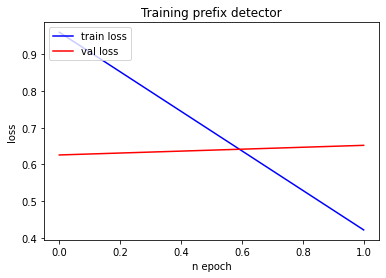

In [31]:
draw_result(epochs, draw_train, draw_test, 'Training prefix detector')

### Получим предсказания для тестовой части

In [23]:
test_df['check_test'] = test_df['paraphrase'] + '\n'

In [26]:
def get_preds(df, dx=16):
    paraphrases = []
    for pos in trange(0, len(df), dx):
        texts = df['check_test'].values[pos:pos+dx].tolist()
        toks = gpt_tokenizer(texts, padding=True, return_tensors='pt').to(device)
        with torch.no_grad():
            gen_toks = gpt_model.generate(toks['input_ids'], max_length=100)
            generated = [gpt_tokenizer.decode(x, skip_special_tokens=True).split('\n')[0] 
                         for x in gen_toks]
        paraphrases.extend(generated)
    return paraphrases

In [27]:
paraphrases = get_preds(test_df)

  0%|          | 0/5 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [40]:
pred_df = test_df.copy()
pred_df['preds'] = paraphrases
pred_df.drop(['full', 'check_test'], axis=1, inplace=True)

In [41]:
pred_df.head(10)

,word,form,sentence,paraphrase,preds
0,скринить,скринит,Эта дура скринит переписки и постит в инстаграм.,Эта дура фотографирует переписки и выставляет ...,Эта дура фотографирует переписки и выставляет ...
1,вайб,вайб,"Не могу это объяснить, но у четверга и 16:00 о...","Не могу это объяснить, но у четверга и 16:00 о...","Не могу это объяснить, но у четверга и 16:00 о..."
2,вайб,вайб,"""Вчера выпал пушистый снег и в воздухе царил н...","""Вчера выпал пушистый снег и в воздухе царило ...","""Вчера выпал пушистый снег и в воздухе царило ..."
3,чек-ап,чекап,Программа чекап в ИНВИТРО создана специально д...,Программа комплексного медицинского обследован...,Программа комплексного медицинского обследован...
4,чек-ап,Чек-Ап,"В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ...","В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ...","В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ..."
5,чек-ап,чек-ап,"Женский и мужской чек-ап, гинекологический чек...",Комплексное медицинское обследование женщин и ...,Комплексное медицинское обследование женщин и ...
6,окей,Окей,"Угашение происходит потому, что мозг делает вы...","Угашение происходит потому, что мозг делает вы...","Угашение происходит потому, что мозг делает вы..."
7,окей,окей,"Приговаривая ""окей"", он вприпрыжку побегал по ...","Приговаривая ""ладно"", он вприпрыжку побегал по...","Приговаривая ""ладно"", он вприпрыжку побегал по..."
8,окей,окей,"Ладно, окей, пацаны его больше не тронут, а ва...","Ладно, договорились, пацаны его больше не трон...","Ладно, договорились, пацаны его больше не трон..."
9,окей,Окей,"Окей, согласился Геннадий, не будем про отпеча...","Хорошо, согласился Геннадий, не будем про отпе...","Хорошо, согласился Геннадий, не будем про отпе..."


In [ ]:
print(pred_df.iloc[1]['sentence'], prepred_df.iloc[1]['paraphrase'], pred_df.iloc[1]['preds'])

### Сохраним веса и таблицу с предсказаниями

In [35]:
torch.save(lora.lora_state_dict(gpt_model), os.path.join(out_dir, 'gpt_lora.pth'))

In [36]:
pred_df = test_df.copy()
pred_df['preds'] = paraphrases
pred_df.to_csv(os.path.join(out_dir, 'gpt_pred_lora.csv'), index=False)